In [1]:
import gpytorch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from func_data_generation import *
from func_polygon import *
from matplotlib.collections import PatchCollection
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle
from torch import nn
from torchsummary import summary
from utils import *
from warp_units import *

dtype = torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using cuda device


In [3]:
class ScaleToBounds(torch.nn.Module):
    """
    Scale the input data so that it lies in between the lower and upper bounds.

    In training (`self.train()`), this module adjusts the scaling factor to the minibatch of data.
    During evaluation (`self.eval()`), this module uses the scaling factor from the previous minibatch of data.

    :param float lower_bound: lower bound of scaled data
    :param float upper_bound: upper bound of scaled data

    Example:
        >>> train_x = torch.randn(10, 5)
        >>> module = gpytorch.utils.grid.ScaleToBounds(lower_bound=-1., upper_bound=1.)
        >>>
        >>> module.train()
        >>> scaled_train_x = module(train_x)  # Data should be between -0.95 and 0.95
        >>>
        >>> module.eval()
        >>> test_x = torch.randn(10, 5)
        >>> scaled_test_x = module(test_x)  # Scaling is based on train_x
    """

    def __init__(self, lower_bound, upper_bound):
        super().__init__()
        self.lower_bound = float(lower_bound)
        self.upper_bound = float(upper_bound)
        self.register_buffer("min_val", torch.tensor(lower_bound))
        self.register_buffer("max_val", torch.tensor(upper_bound))

    def forward(self, x):
        if self.training:
            min_val = x.min()
            max_val = x.max()
            self.min_val.data = min_val
            self.max_val.data = max_val
        else:
            min_val = self.min_val
            max_val = self.max_val
            # Clamp extreme values
            x = x.clamp(min_val, max_val)

        diff = max_val - min_val
        x = (x - min_val) * (
            0.95 * (self.upper_bound - self.lower_bound) / diff
        ) + 0.95 * self.lower_bound
        return x

In [3]:
class WarpModel(torch.nn.Sequential):
    def __init__(self):
        super(WarpModel, self).__init__()
        self.add_module(
            "axial_dim0", AxialWarpUnit(dim=0, res=10, grad=20, lims=[0, 1.0])
        )
        self.add_module(
            "axial_dim1", AxialWarpUnit(dim=1, res=10, grad=20, lims=[-1.0, 0])
        )
        self.add_module("rbf_seq1", rbfunit_sequential(res=1, ylim=[-1, 0]))
        self.add_module("rbf_seq2", rbfunit_sequential(res=2, ylim=[-1, 0]))

        self.add_module("rbf_seq3", rbfunit_sequential(res=3, ylim=[-1, 0]))

        self.add_module("mobius", MobiusWarpUnit())


class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, warp_model):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.space_transform = warp_model
        self.scale_to_bounds = ScaleToBounds(0, 1)

    def forward(self, x):
        # We're first putting our data through a deep net (feature extractor)
        # We're also scaling the features so that they're nice values
        projected_x = self.space_transform(x)
        projected_x = self.scale_to_bounds(projected_x)
        #         projected_x = projected_x - projected_x.min(0)[0]
        #         projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
# generate a warp model
random_seed = 136
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

warp_model = WarpModel()

In [5]:
rbfunit_1 = RBFWarpUnit(128, 0.25, -0.125)
rbfunit_2 = RBFWarpUnit(128, 0.125, -0.125)
rbfunit_1.weight_true = torch.nn.Parameter(torch.tensor(1.0))
rbfunit_2.weight_true = torch.nn.Parameter(torch.tensor(1.0))
rbfs = nn.Sequential()
rbfs.add_module("rbf1", rbfunit_1)
rbfs.add_module("rbf2", rbfunit_2)

In [7]:
warp_model.rbf_seq2[65].r[0].item()

0.25

# RBF Transformation Unit

Saving figure rbf_unit_cn


/home/nicegeek/Projects/code_deep_kernel_learning/utils.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


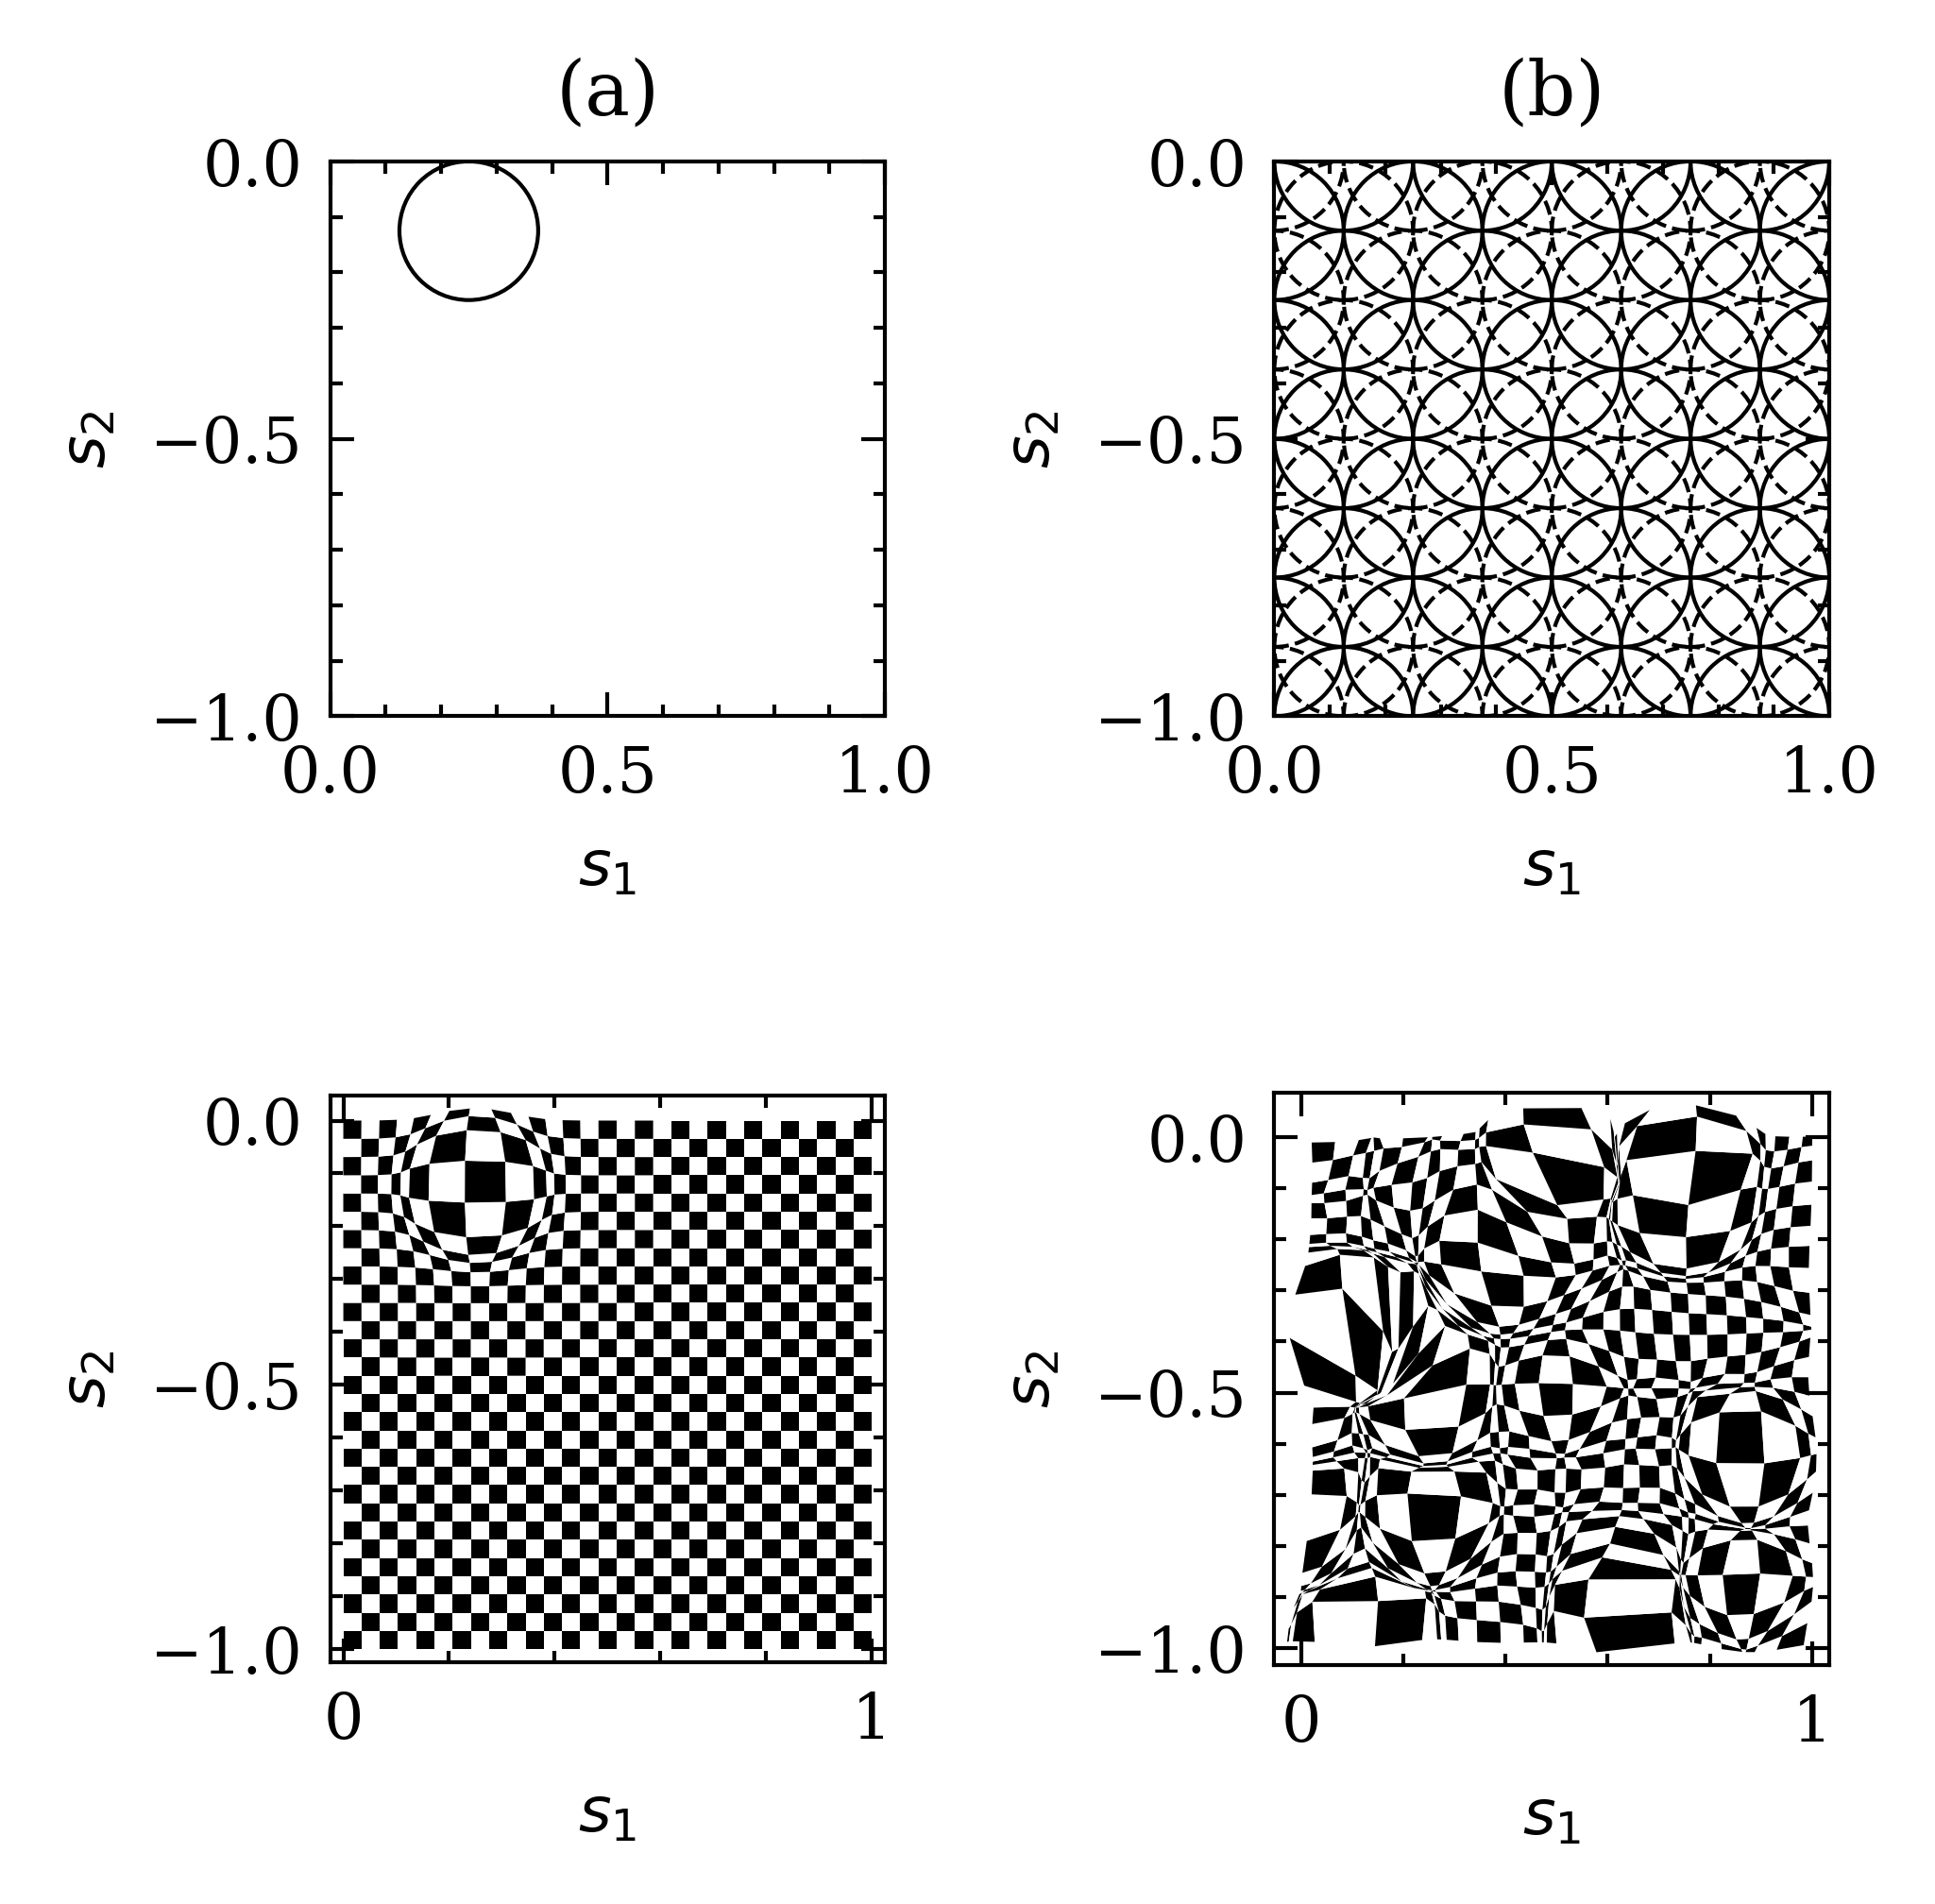

In [8]:
with plt.style.context(["science", "ieee", "no-latex"]):
    fig = plt.figure(constrained_layout=True, figsize=(3.3, 3.3))
    gs = GridSpec(2, 2, figure=fig, wspace=0.1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    axes = [ax1, ax2, ax3, ax4]

    ax1.add_patch(Circle((0.25, -0.125), 0.125, fill=False, linewidth=0.5))
    ax1.set_ylim([-1, 0])
    for i, rbf in enumerate(warp_model.rbf_seq2):
        linestyle = "-" if (i % 2 != 0) else "--"
        ax2.add_patch(
            Circle(
                (rbf.r[0].item(), rbf.r[1].item()),
                0.125,
                fill=False,
                linewidth=0.5,
                linestyle=linestyle,
            )
        )
    #     ax2.add_collection(p)
    ax2.set_ylim([-1, 0])
    chessboard_from_model(rbfunit_1, chessgrid_res=30, ax=ax3)
    chessboard_from_model(warp_model.rbf_seq2, chessgrid_res=30, ax=ax4)
    for ax in axes:
        ax.set_aspect("equal")
        ax.set_xlabel(r"$s_1$")
        ax.set_ylabel(r"$s_2$")
    ax1.set_title("(a)")
    ax2.set_title("(b)")
save_fig("rbf_unit_cn", fig_extension='svg')

Saving figure rbf_unit


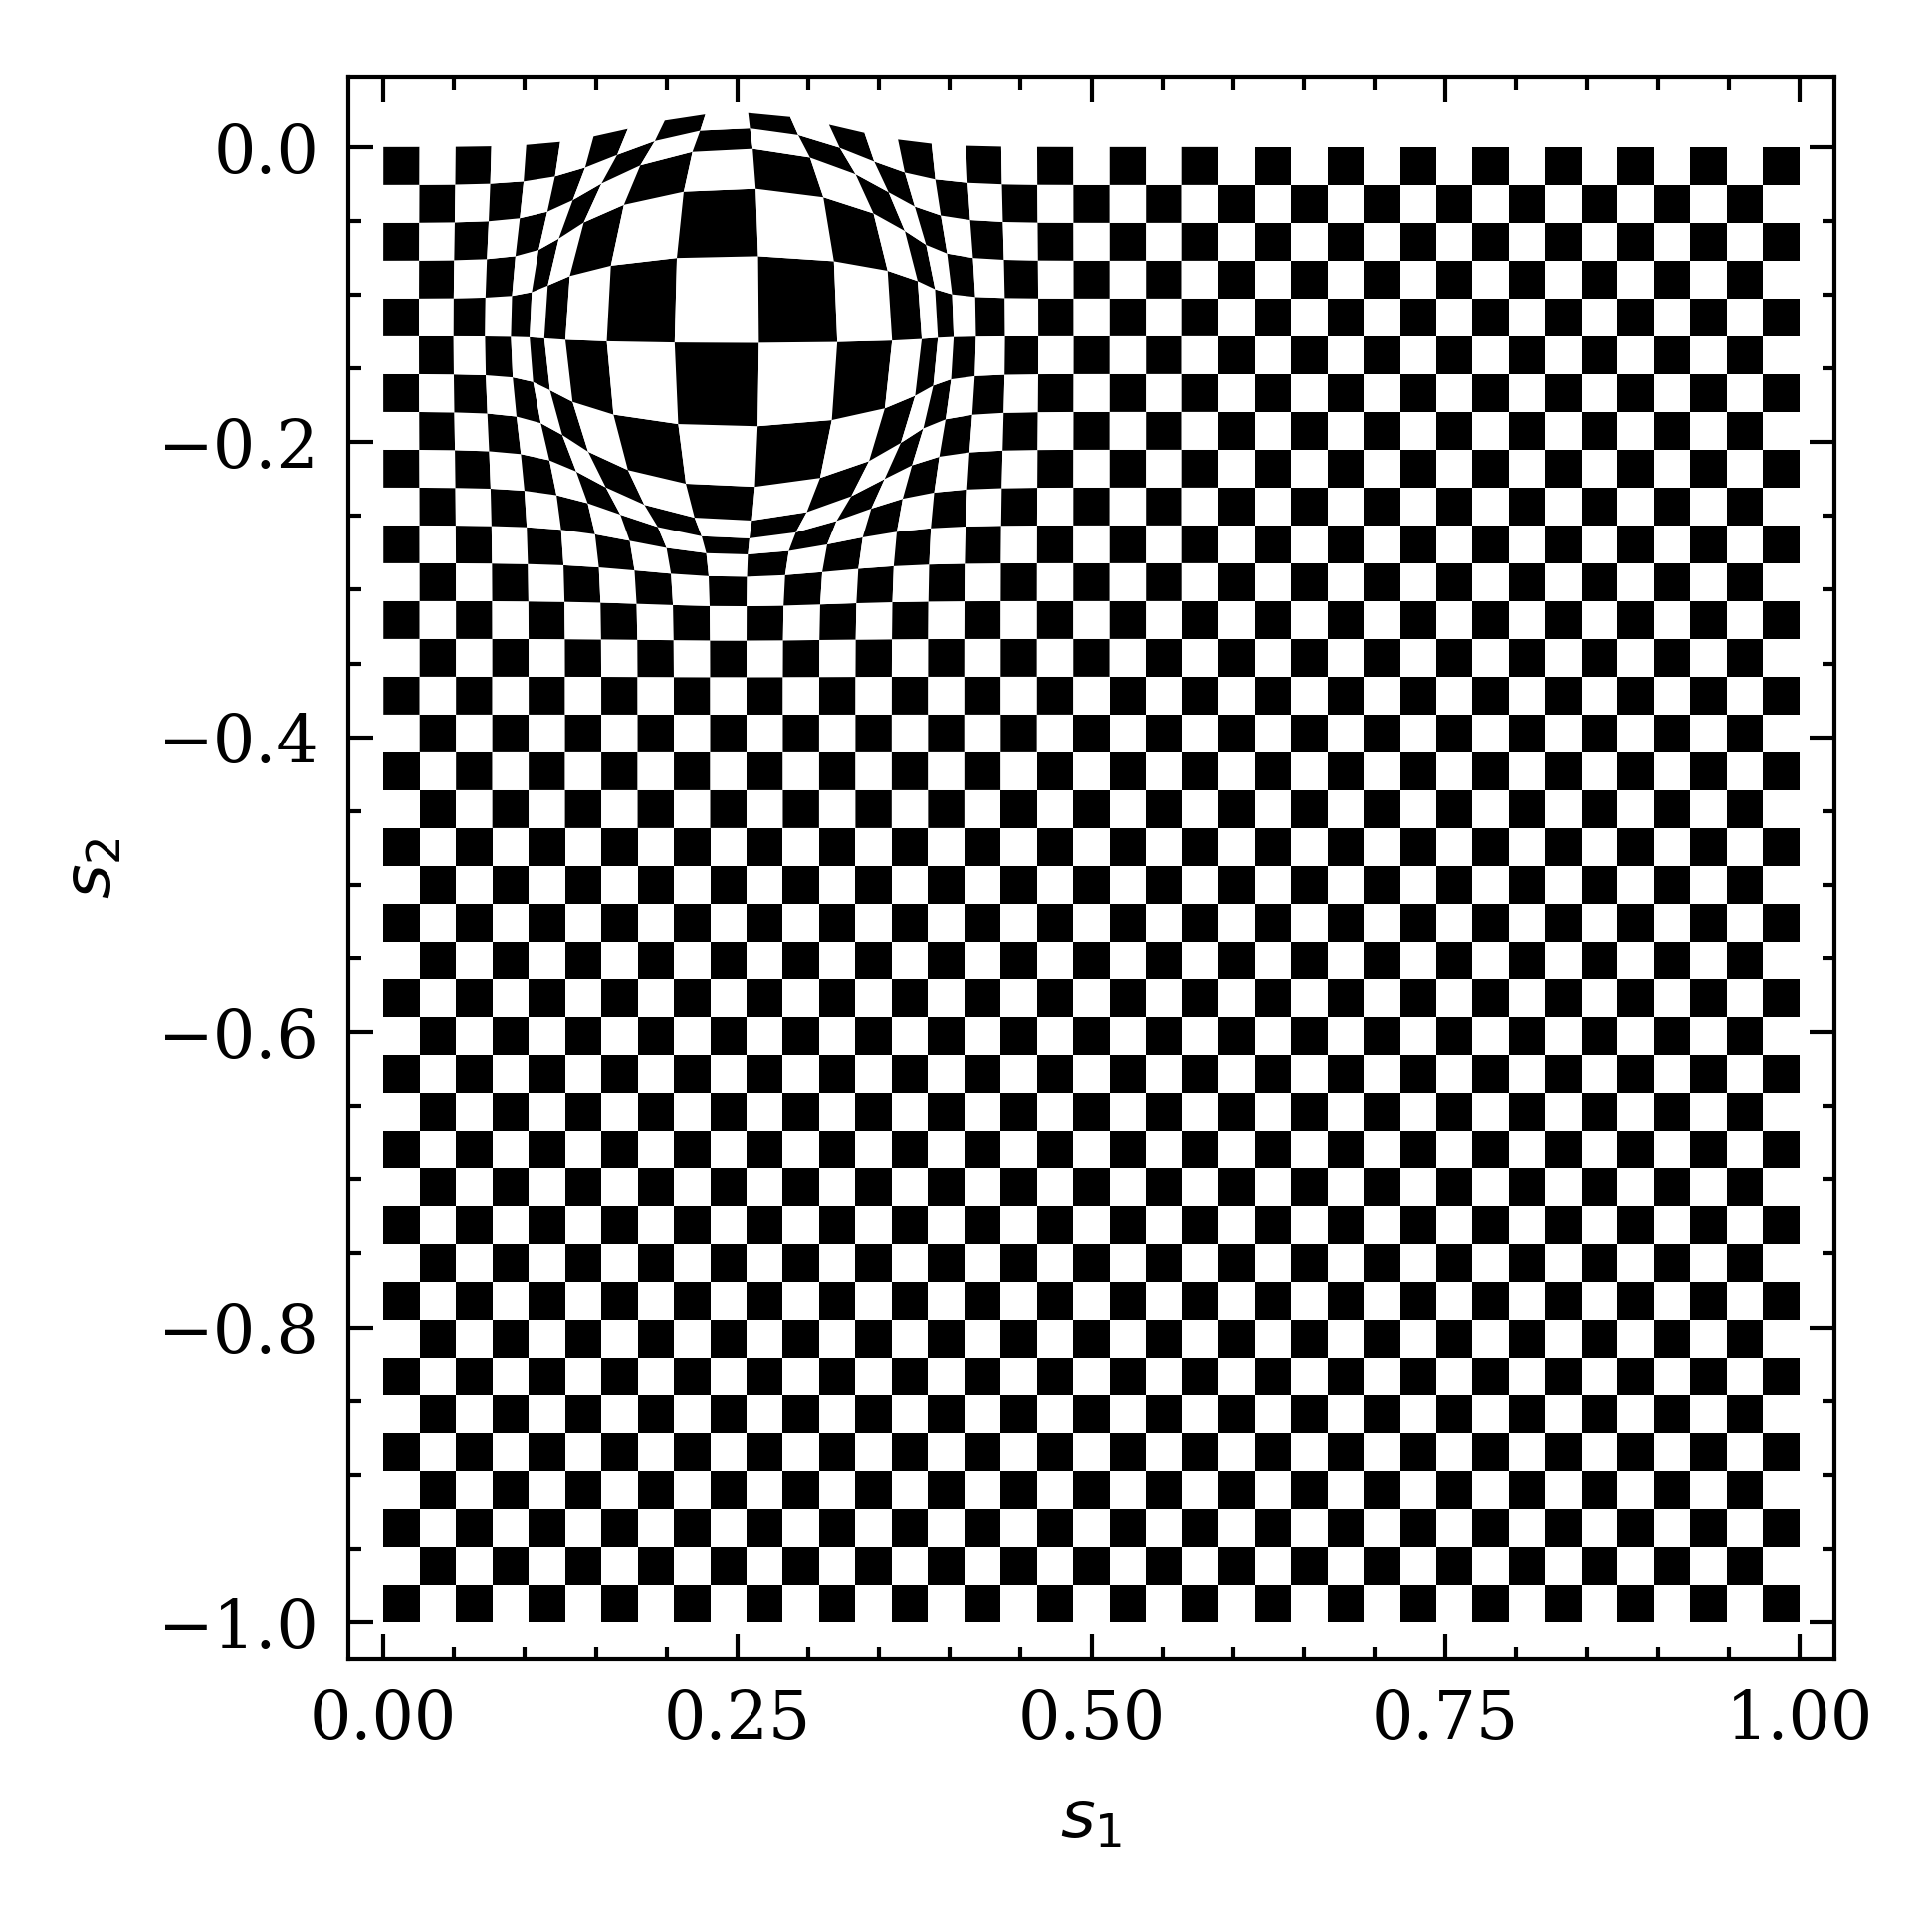

In [8]:
with plt.style.context(
    [
        "science",
        "ieee",
        "no-latex",
    ]
):
    fig, ax = plt.subplots(figsize=(3.3, 3.3))
    chessboard_from_model(rbfunit_1, chessgrid_res=40, ax=ax)
    ax.set_xlabel(r"$s_1$")
    ax.set_ylabel(r"$s_2$")
save_fig("rbf_unit")

# Mobius Transformation Unit

In [4]:
mobius = MobiusWarpUnit()
scale = ScaleToBounds(0, 1)
mob = nn.Sequential()
mob.add_module("mobius", mobius)
mob.add_module("scale", scale)

Saving figure mobius_unit_cn


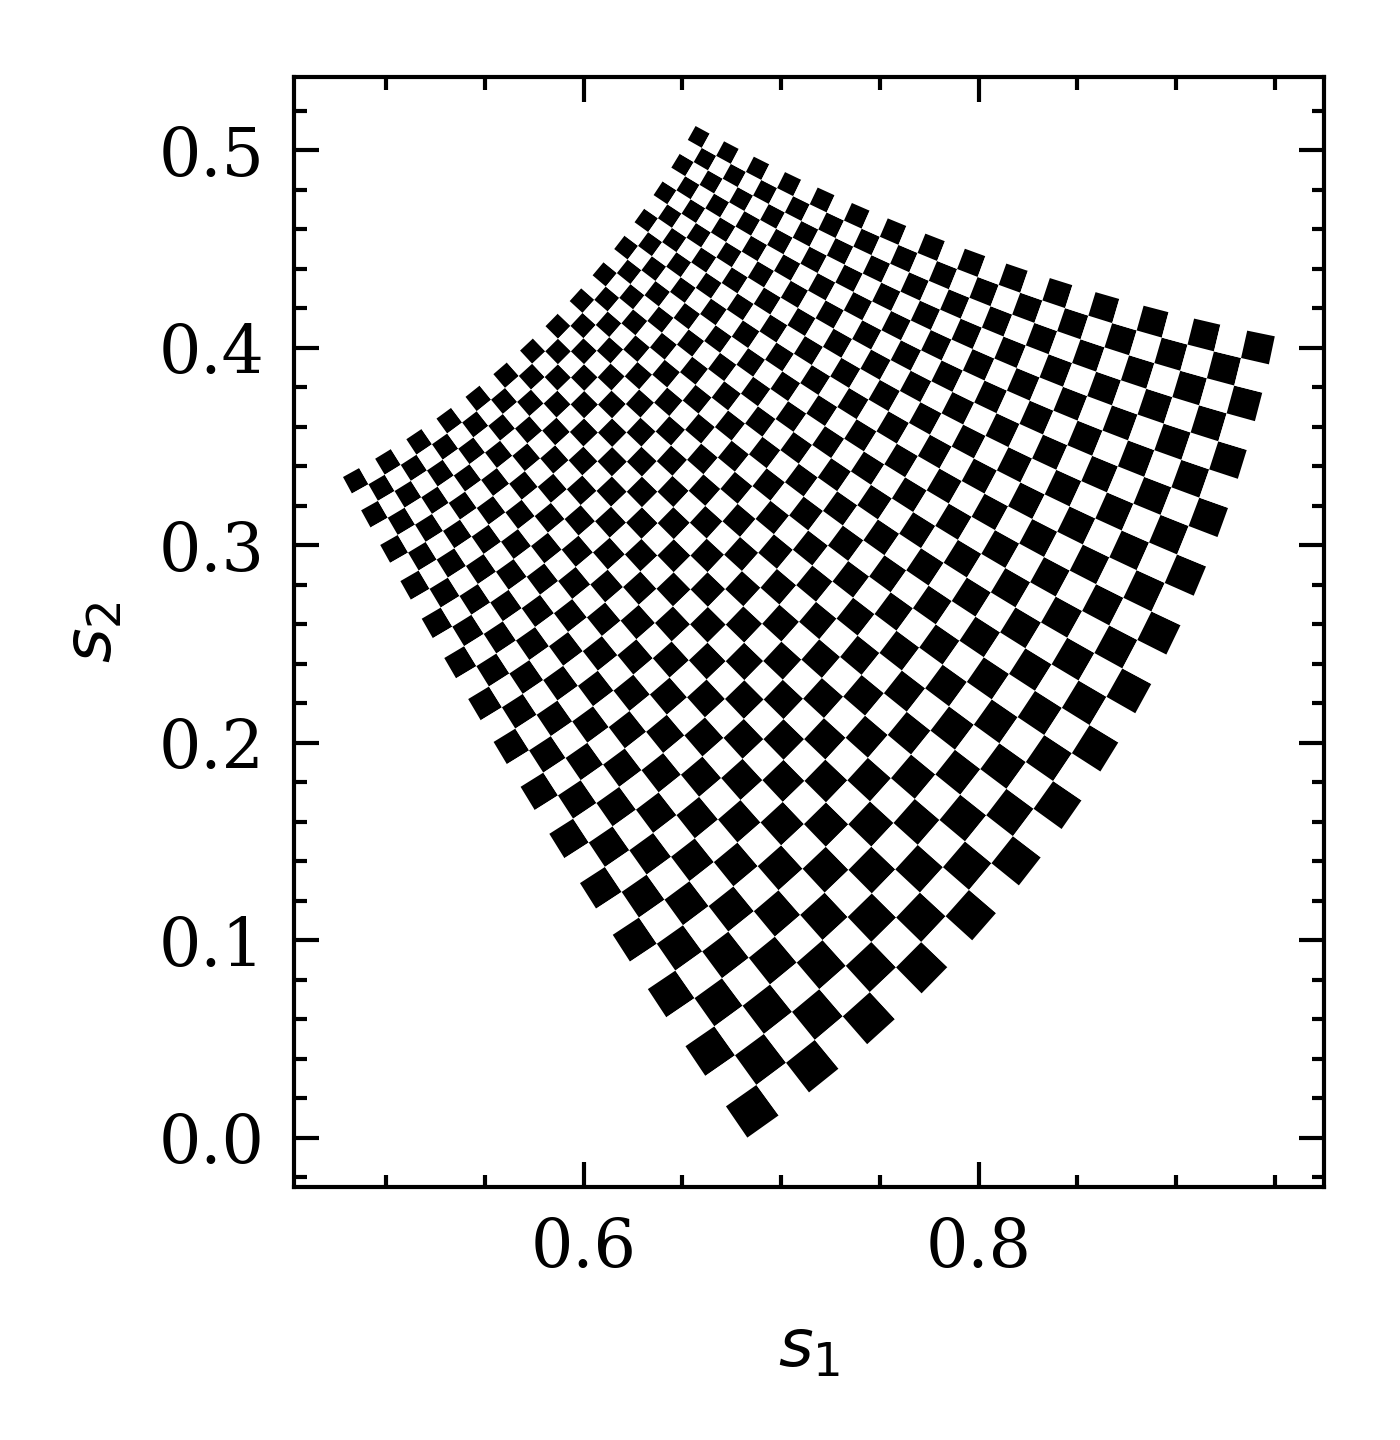

In [6]:
with plt.style.context(
    [
        "science",
        "ieee",
        "no-latex",
    ]
):
    fig, ax = plt.subplots()
    chessboard_from_model(mob, chessgrid_res=30, ax=ax)
    ax.set_xlabel(r"$s_1$")
    ax.set_ylabel(r"$s_2$")
    ax.set_aspect("equal")
save_fig("mobius_unit_cn", fig_extension='svg')

# Deep Kernel

In [11]:
data_dim = 2


class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module("linear1", torch.nn.Linear(data_dim, 1000))
        self.add_module("relu1", torch.nn.ReLU())
        self.add_module("linear2", torch.nn.Linear(1000, 500))
        self.add_module("relu2", torch.nn.ReLU())
        self.add_module("linear3", torch.nn.Linear(500, 50))
        self.add_module("relu3", torch.nn.ReLU())
        self.add_module("linear4", torch.nn.Linear(50, 2))

In [25]:
dk = LargeFeatureExtractor()
bound = ScaleToBounds(0, 1)
dk_bound = nn.Sequential()
dk_bound.add_module("dk", dk)
dk_bound.add_module("bound", bound)

Saving figure dkl


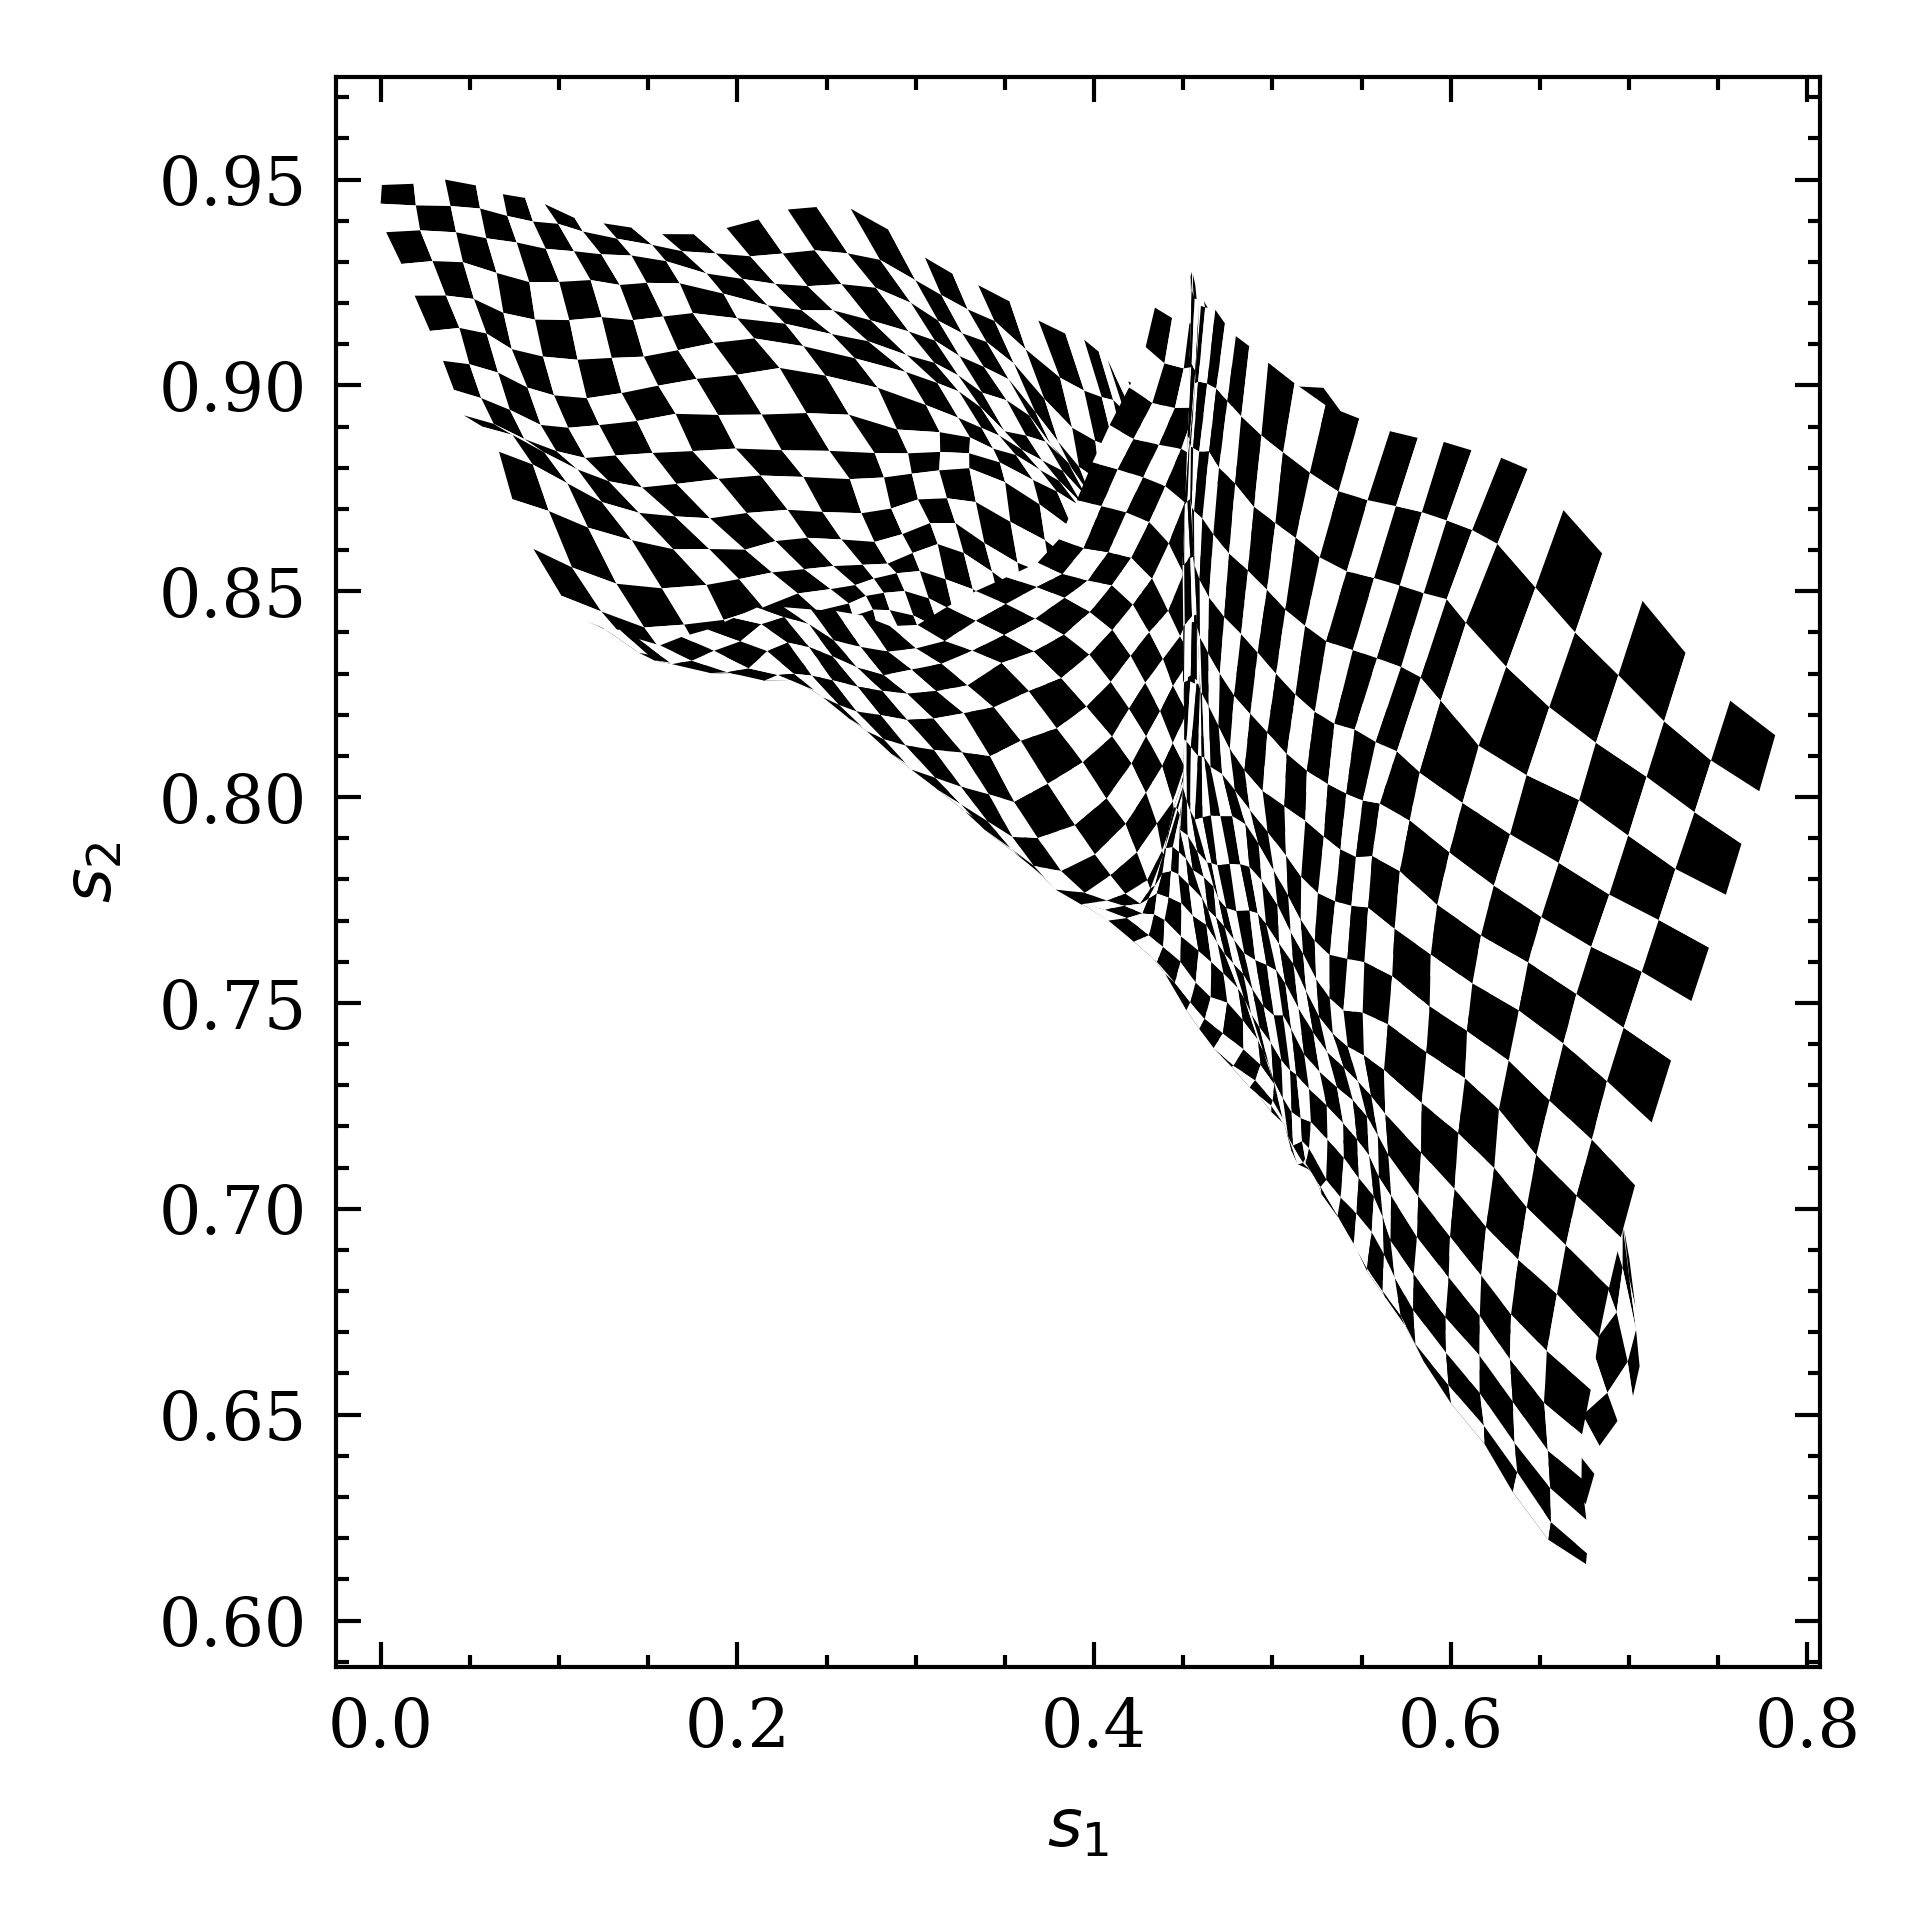

In [26]:
with plt.style.context(
    [
        "science",
        "ieee",
        "no-latex",
    ]
):
    fig, ax = plt.subplots(figsize=(3.3, 3.3))
    chessboard_from_model(dk_bound, chessgrid_res=40, ax=ax)
    ax.set_xlabel(r"$s_1$")
    ax.set_ylabel(r"$s_2$")
save_fig("dkl")

In [27]:
rbfunit_0 = RBFWarpUnit(128, 0.25, -0.125)
rbfunit_0.weight_true = torch.nn.Parameter(torch.tensor(-0.8))

Saving figure chess


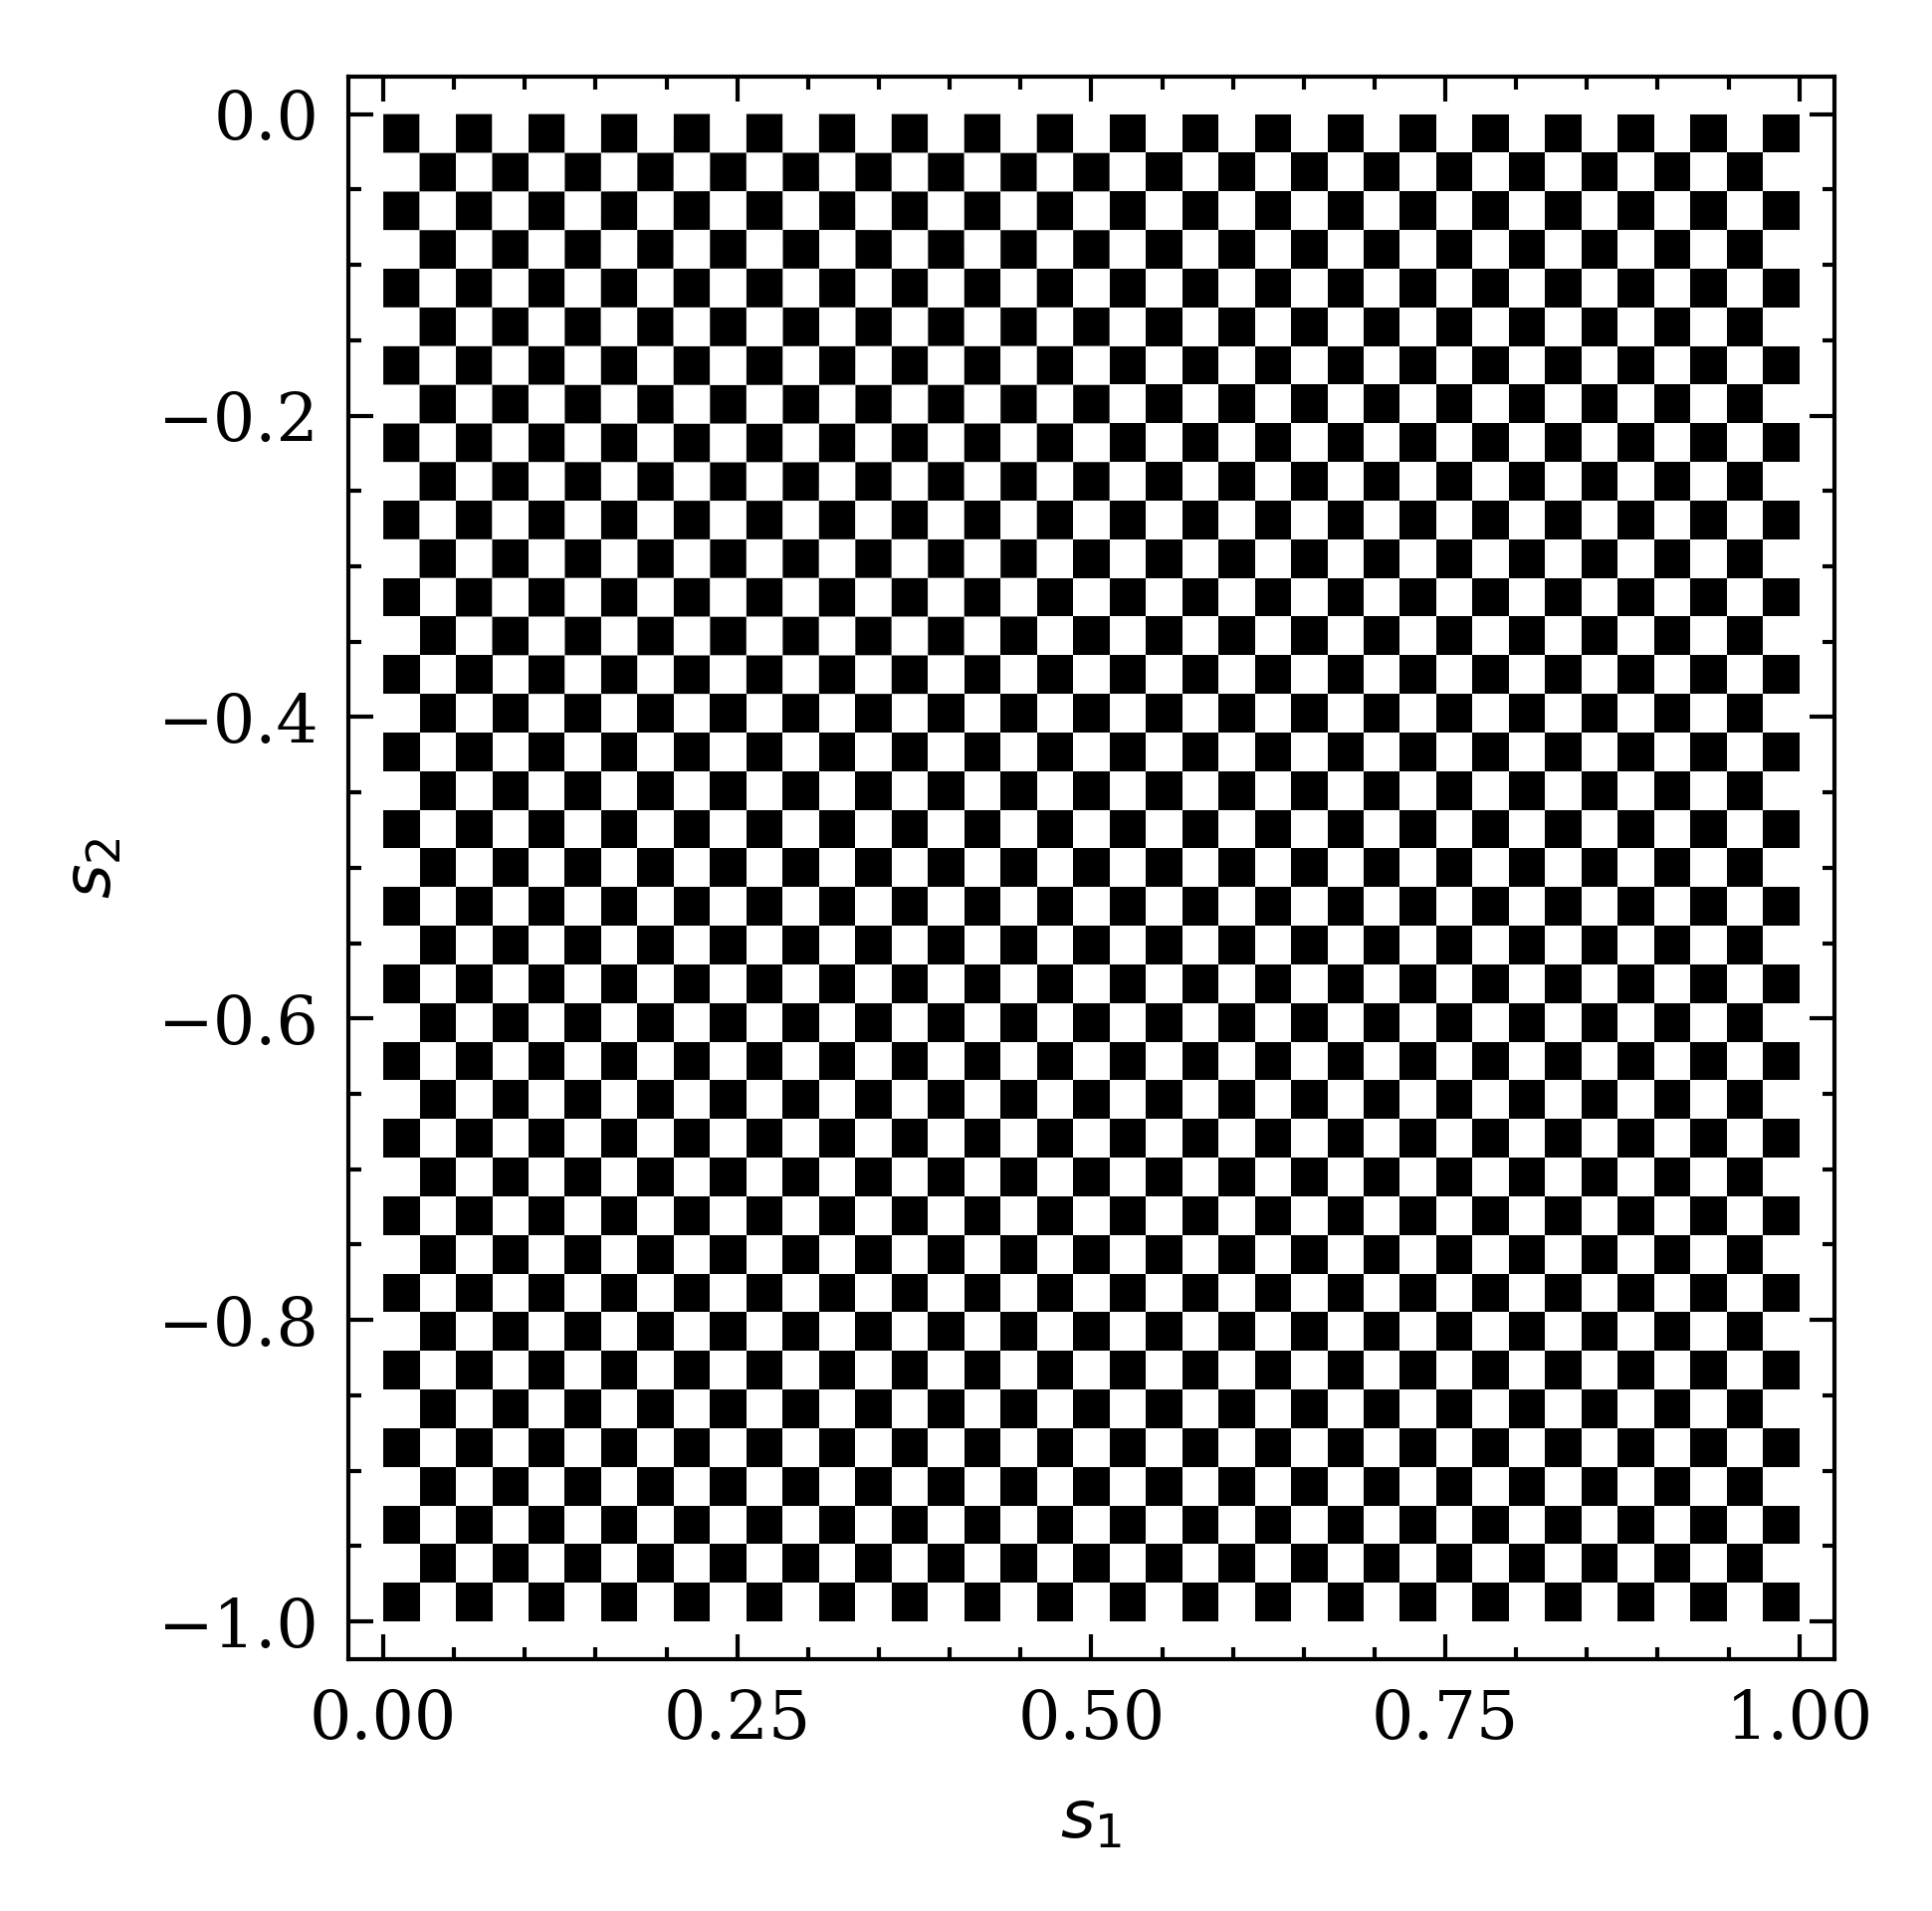

In [29]:
with plt.style.context(
    [
        "science",
        "ieee",
        "no-latex",
    ]
):
    fig, ax = plt.subplots(figsize=(3.3, 3.3))
    chessboard_from_model(rbfunit_0, chessgrid_res=40, ax=ax)
    ax.set_xlabel(r"$s_1$")
    ax.set_ylabel(r"$s_2$")
save_fig("chess")